# Image Classification PyTorch 05

Dataset: https://www.kaggle.com/datasets/tongpython/cat-and-dog

The data is balance:
- Train 4000 cats and 4000 dogs
- Test 1000 cats and 1000 dogs

- Using 2 Conv2d and 2 Linear
- add Dropout
- use augmentation

Import function

In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data.dataloader import DataLoader
from torchvision import datasets, transforms, models
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
TRAIN_FOLDER = '~/data1/data/mlzoomcamp25/catdog/train'
TEST_FOLDER = '~/data1/data/mlzoomcamp25/catdog/test'

SEED = 42
BATCH_SIZE = 20
IMAGE_SIZE = 150
EPOCHS = 15

In [3]:
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False



In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),    
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_val_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [7]:
train_dataset = datasets.ImageFolder(TRAIN_FOLDER, transform=train_transform)
test_dataset  = datasets.ImageFolder(TEST_FOLDER,  transform=test_val_transform)

# verify the number of classes
num_classes = len(train_dataset.classes)
print("Classes:", train_dataset.classes)


Classes: ['cats', 'dogs']


In [8]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=6, pin_memory=True, persistent_workers=True, prefetch_factor=4
                          )

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=6, pin_memory=True, persistent_workers=True, prefetch_factor=4
                         )


In [9]:
# create model
class CatDogModel(nn.Module):
    def __init__(self):
        super(CatDogModel, self).__init__()

        # Hout​=(Input+2Padding−Kernel​)/Stride+1
        self.base_model = nn.Sequential(
            # (150 + 2*0 - 3)/1 + 1 = 148
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=0), # (64, 148, 148)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), # (64, 74, 74)
            # (74 + 2*0 - 3)/1 + 1 = 72
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=0), # (128, 72, 72)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), # (128, 36, 36)
        )
        self.flatten = nn.Flatten() # (128, 36*36,) = 165888
        self.fc = nn.Sequential(
            nn.Linear(128 * 36 * 36, 1024), # (1024,)
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 1), # (1,)
        )
               

    def forward(self, x):
        x = self.base_model(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x 

In [10]:
def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        labels = labels.float()
        if labels.ndim == 1:
            labels = labels.unsqueeze(1)  # Ensure shape [batch, 1]

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward() # compute gradients
        optimizer.step() # update weights

        total_loss += loss.item()

        preds = torch.sigmoid(outputs) > 0.5
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    accuracy = correct / total
    return total_loss / len(loader), accuracy


In [11]:
def validate(model, loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            labels = labels.float()
            if labels.ndim == 1:
                labels = labels.unsqueeze(1)  # Ensure shape [batch, 1]

            outputs = model(imgs)
            loss = criterion(outputs, labels)

            total_loss += loss.item()

            preds = torch.sigmoid(outputs) > 0.5
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    return total_loss / len(loader), accuracy


In [12]:

model = CatDogModel()
model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1.0e-4)

Training loop

In [13]:

arr_train_acc = []
arr_train_loss = []

arr_test_acc = []
arr_test_loss = []

idx = 0
for epoch in range(EPOCHS):

    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
    test_loss, test_acc = validate(model, test_loader, criterion)

    arr_train_acc.append(train_acc)
    arr_train_loss.append(train_loss)
    arr_test_acc.append(test_acc)
    arr_test_loss.append(test_loss)

    print(idx)
    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val Loss  : {test_loss:.4f} | Val Acc: {test_acc:.4f}")

    idx += 1


0
Epoch 1/15
  Train Loss: 0.6902 | Train Acc: 0.5423
  Val Loss  : 0.6863 | Val Acc: 0.5868
1
Epoch 2/15
  Train Loss: 0.6846 | Train Acc: 0.5706
  Val Loss  : 0.6810 | Val Acc: 0.6026
2
Epoch 3/15
  Train Loss: 0.6799 | Train Acc: 0.5976
  Val Loss  : 0.6777 | Val Acc: 0.5932
3
Epoch 4/15
  Train Loss: 0.6764 | Train Acc: 0.5970
  Val Loss  : 0.6720 | Val Acc: 0.6317
4
Epoch 5/15
  Train Loss: 0.6730 | Train Acc: 0.6087
  Val Loss  : 0.6681 | Val Acc: 0.6347
5
Epoch 6/15
  Train Loss: 0.6688 | Train Acc: 0.6121
  Val Loss  : 0.6644 | Val Acc: 0.6317
6
Epoch 7/15
  Train Loss: 0.6655 | Train Acc: 0.6210
  Val Loss  : 0.6616 | Val Acc: 0.6312
7
Epoch 8/15
  Train Loss: 0.6619 | Train Acc: 0.6235
  Val Loss  : 0.6579 | Val Acc: 0.6406
8
Epoch 9/15
  Train Loss: 0.6585 | Train Acc: 0.6285
  Val Loss  : 0.6544 | Val Acc: 0.6421
9
Epoch 10/15
  Train Loss: 0.6562 | Train Acc: 0.6350
  Val Loss  : 0.6522 | Val Acc: 0.6327
10
Epoch 11/15
  Train Loss: 0.6531 | Train Acc: 0.6271
  Val Loss  :

Plot the result

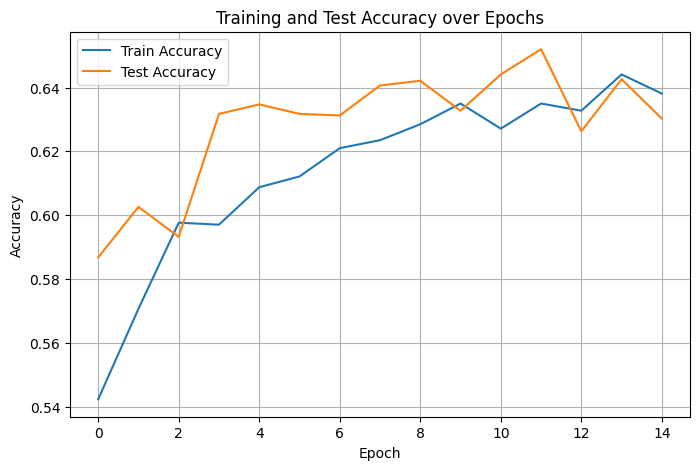

In [14]:

plt.figure(figsize=(8, 5))
plt.plot(arr_train_acc, label='Train Accuracy')
plt.plot(arr_test_acc, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

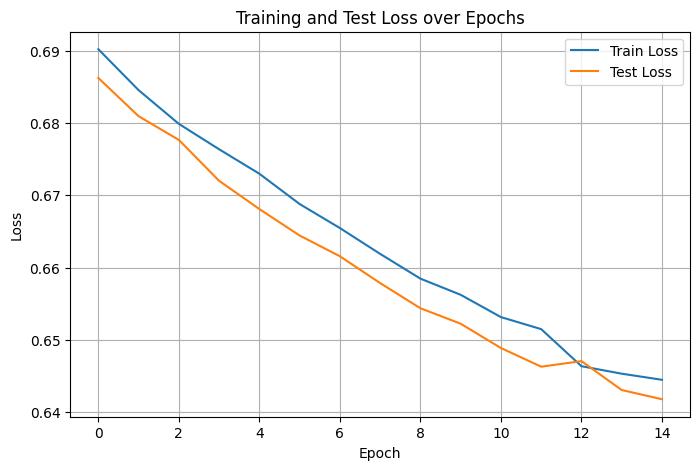

In [15]:

plt.figure(figsize=(8, 5))
plt.plot(arr_train_loss, label='Train Loss')
plt.plot(arr_test_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [16]:

df_train = pd.DataFrame({
    'train_loss': arr_train_loss,
    'train_accuracy': arr_train_acc
})
df_train

,train_loss,train_accuracy
0,0.690238,0.542286
1,0.684572,0.570643
2,0.679900,0.597626
3,0.676383,0.597002
4,0.672995,0.608745
5,0.668802,0.612117
6,0.665472,0.620987
7,0.661896,0.623485
8,0.658469,0.628482
9,0.656231,0.634978


In [17]:

df_test = pd.DataFrame({
    'val_loss': arr_test_loss,
    'val_accuracy': arr_test_acc
})
df_test

,val_loss,val_accuracy
0,0.686258,0.586752
1,0.680962,0.602570
2,0.677678,0.593178
3,0.672016,0.631735
4,0.668103,0.634701
5,0.664440,0.631735
6,0.661568,0.631241
7,0.657852,0.640633
8,0.654369,0.642116
9,0.652226,0.632724
